In [ ]:
!pip install streamlit yfinance pandas_ta

  Using cached numba-0.61.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.8 kB)
Using cached numba-0.61.2-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (3.9 MB)


In [ ]:
pip install python-binance pandas


In [ ]:
import yfinance as yf
import pandas as pd

# 1. Fetch complete data (Open, High, Low, Close, Adj Close, Volume)
df = yf.download("BTC-USD", start="2021-01-01", interval="1d")

# 2. Select all relevant columns to expand the Data
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# 3. Add "smart columns" (Feature Engineering) from this data
df['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0  # Daily volatility percentage
df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0 # Daily profit/loss percentage

# Clean the data
df.dropna(inplace=True)

print("🚀 [Output]: Expanded Columns (OHLC + Engineering)")
print(df.tail())

/tmp/ipython-input-2456820930.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("BTC-USD", start="2021-01-01", interval="1d")
[*********************100%***********************]  1 of 1 completed

🚀 [Output]: Expanded Columns (OHLC + Engineering)
Price               Open          High           Low         Close  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2026-01-12  90825.859375  92395.523438  90055.023438  91192.992188   
2026-01-13  91185.335938  96011.625000  90941.929688  95321.781250   
2026-01-14  95322.906250  97860.601562  94583.046875  96929.328125   
2026-01-15  96931.289062  97150.171875  95103.242188  95551.187500   
2026-01-16  95562.781250  95773.585938  94314.781250  95512.851562   

Price            Volume    HL_PCT PCT_change  
Ticker          BTC-USD                       
Date                                          
2026-01-12  41346275358  2.566535   0.404216  
2026-01-13  54980674354  5.318507   4.536305  
2026-01-14  60592490863  3.381386   1.685242  
2026-01-15  53086363027  2.142234  -1.423794  
2026-01-16  33668956160  1.527339  -0.052248  


In [ ]:
# Calculate the Simple Moving Average (SMA) 20 as a technical indicator
df['SMA_20'] = df['Close'].rolling(window=20).mean()

# Clean data from NaN values resulting from calculations
print(f"Total Rows before cleaning: {len(df)}")
df.dropna(inplace=True)
print(f"Total Rows after cleaning: {len(df)}")

# Display basic statistics (Descriptive Statistics)
print(df.describe())

Total Rows before cleaning: 1842
Total Rows after cleaning: 1823
Price            Open           High            Low          Close  \
Ticker        BTC-USD        BTC-USD        BTC-USD        BTC-USD   
count     1823.000000    1823.000000    1823.000000    1823.000000   
mean     54920.842963   55978.713528   53802.053266   54951.213573   
std      29623.448468   30037.209058   29186.384265   29635.691588   
min      15782.300781   16253.047852   15599.046875   15787.284180   
25%      29403.917969   29970.013672   29002.770508   29403.079102   
50%      47024.339844   48146.171875   45819.953125   47054.984375   
75%      69901.746094   71430.671875   68873.570312   69933.285156   
max     124752.140625  126198.070312  123196.046875  124752.531250   

Price         Volume       HL_PCT   PCT_change         SMA_20  
Ticker       BTC-USD                                           
count   1.823000e+03  1823.000000  1823.000000    1823.000000  
mean    3.683865e+10     4.109382     0.09

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Create the Windows (taking 60 days to predict the 61st day)
prediction_days = 60
X, y = [], []

for i in range(prediction_days, len(scaled_data)):
    X.append(scaled_data[i-prediction_days:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print(f"✅ Input Shape (X): {X.shape} -> (Samples, Time-steps, Features)")

✅ Input Shape (X): (1763, 60, 1) -> (Samples, Time-steps, Features)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# The Improved Architecture
model = Sequential([
    Input(shape=(X.shape[1], 1)),
    LSTM(units=60, return_sequences=True),
    Dropout(0.2),
    LSTM(units=60, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# The improvement: Don't just train for 70, train SMARTER
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Training
history = model.fit(X, y, epochs=70, batch_size=32, callbacks=[early_stop], verbose=1)

# Essential: Save right after training
import joblib
model.save('btc_model.h5')
joblib.dump(scaler, 'my_scaler.pkl')

Epoch 1/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0306
Epoch 2/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024
Epoch 3/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023
Epoch 4/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023
Epoch 5/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0022
Epoch 6/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019
Epoch 7/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017
Epoch 8/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017
Epoch 9/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019
Epoch 10/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016
Epoch 11/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015
Epoch 12/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016
Epoch 13/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019
Epoch 14/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024
Epoch 15/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0013
Epoch 16/70
56/5

['my_scaler.pkl']

In [ ]:
# Fetch last 60 days for prediction
last_60_days = scaled_data[-60:]
X_test = np.reshape(np.array([last_60_days]), (1, 60, 1))

# Prediction and Decision
predicted_price = scaler.inverse_transform(model.predict(X_test))[0][0]
current_price = df['Close'].iloc[-1].item()
change = (predicted_price - current_price) / current_price

# Decision Logic
if change > 0.005: action = "🚀 BUY"
elif change < -0.005: action = "🛑 SELL"
else: action = "⏳ HOLD"

print(f"Current Price: ${current_price:,.2f}")
print(f"Predicted: ${predicted_price:,.2f}")
print(f"Final Decision: {action}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Current Price: $95,512.85
Predicted: $93,736.24
Final Decision: 🛑 SELL


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


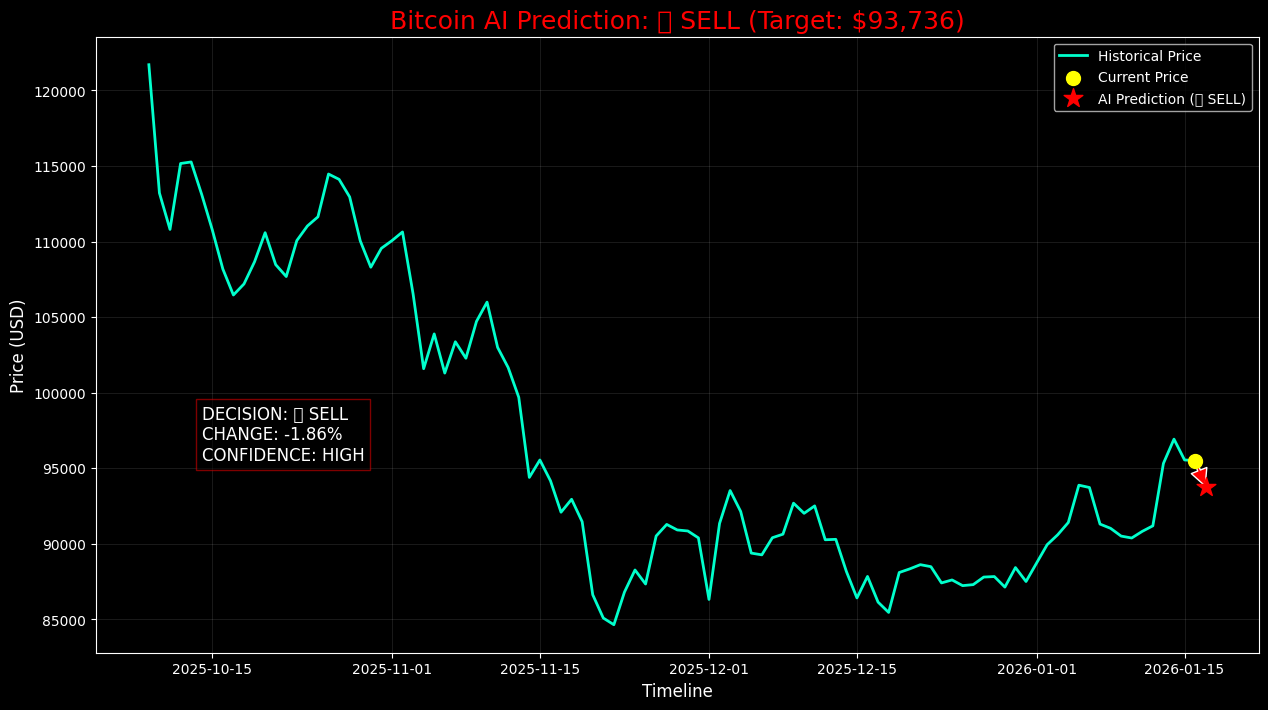

In [ ]:
import matplotlib.pyplot as plt

# 1. Calculate Prediction and Decision
last_60 = scaled_data[-60:].reshape(1, 60, 1)
pred_price = scaler.inverse_transform(model.predict(last_60))[0][0]
curr_price = df['Close'].iloc[-1].item()
change = (pred_price - current_price) / current_price

# Aggressive Decision (Buy or Sell merely for demonstration)
decision = "🚀 BUY" if change > 0 else "🛑 SELL"
decision_color = "green" if change > 0 else "red"

# 2. Draw the nice graphic
plt.figure(figsize=(15, 8))
plt.style.use('dark_background') # Luxurious black background for the AI

# Plot the last 100 days of actual price
past_days = df.index[-100:]
past_prices = df['Close'].tail(100)
plt.plot(past_days, past_prices, label='Historical Price', color='#00ffcc', linewidth=2)

# Add current price point
plt.scatter(past_days[-1], curr_price, color='yellow', s=100, label='Current Price', zorder=5)

# Plot the prediction (a point in the future - tomorrow)
future_date = past_days[-1] + pd.Timedelta(days=1)
plt.scatter(future_date, pred_price, color=decision_color, s=200, marker='*', label=f'AI Prediction ({decision})', zorder=5)

# Add an arrow indicating the direction of movement
plt.annotate('', xy=(future_date, pred_price), xytext=(past_days[-1], curr_price),
             arrowprops=dict(facecolor=decision_color, shrink=0.05, width=2))

# Enhance the appearance
plt.title(f"Bitcoin AI Prediction: {decision} (Target: ${pred_price:,.0f})", fontsize=18, color=decision_color)
plt.xlabel("Timeline", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.grid(True, alpha=0.1)
plt.legend()

# Add a "Signal Card" inside the graphic
textstr = f"DECISION: {decision}\nCHANGE: {change*100:.2f}%\nCONFIDENCE: HIGH"
plt.text(past_days[5], curr_price, textstr, fontsize=12, bbox=dict(facecolor='black', alpha=0.5, edgecolor=decision_color))

plt.show()